# Radial Velocity Orbit-fitting with RadVel

## Week 6, Intro-to-Astro 2021
### Written by Ruben Santana & Sarah Blunt, 2018
#### Updated by Joey Murphy, June 2020
#### Updated by Corey Beard, July 2021


## Background information
Radial velocity measurements tell us how the velocity of a star changes along the direction of our line of sight. These measurements are made using Doppler Spectroscopy, which looks at the spectrum of a star and measures shifts in known absorption lines. Here is a nice [GIF](https://polytechexo.files.wordpress.com/2011/12/spectro.gif) showing the movement of a star due to the presence of an orbiting planet, the shift in the stellar spectrum, and the corresponding radial velocity measurements. 

This tutorial will cover a lot of new topics and build on ones we just learned. We don't have time to review all of them right now, so you're encouraged to read the following references before coming back to complete the tutorial as one of your weekly assignments.
- [Intro to the Radial Velocity Technique](http://exoplanets.astro.yale.edu/workshop/EPRV/Bibliography_files/Radial_Velocity.pdf) (focus on pgs. 1-6)
- [Intro to Periodograms](https://arxiv.org/pdf/1703.09824.pdf) (focus on pgs. 1-30)
- [Intro to Markov Chain Monte Carlo Methods](https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50) (link also found in the MCMC resources from the Bayesian fitting methods and MCMC tutorial)


## About this tutorial
In this tutorial, you will use the California Planet Search Python package [RadVel](https://github.com/California-Planet-Search/radvel) to characterize the exoplanets orbiting the star K2-24 (EPIC 203771098) using radial velocity measurements. This tutorial is a modification of the "[K2-24 Fitting & MCMC](https://github.com/California-Planet-Search/radvel/blob/master/docs/tutorials/K2-24_Fitting%2BMCMC.ipynb)" tutorial on the RadVel GitHub page. 

There are several coding tasks for you to accomplish in this tutorial. Each task is indicated by a `#TODO` comment.

In this tutorial, you will:
- estimate planetary orbital periods using a periodogram
- perform a maximum likelihood orbit fit with RadVel 
- create a residuals plot
- perform a Markov Chain Monte Carlo (MCMC) fit to characterize orbital parameter uncertainty

## Outline
1. RadVel Installation
2. Importing Data
3. Finding Periods
4. Defining and Initializing a Model
5. Maximum Likelihood Fitting
6. Residuals
7. MCMC

## 1. Installation
We will begin by making sure we have all the python packages needed for the tutorial. First, [install RadVel](http://radvel.readthedocs.io/en/latest/quickstartcli.html#installation) by typing:

`pip install radvel` at the command line. (Some warning messages may print out, but I (Corey) was able to install RadVel successfully in a new Anaconda environment using python=3.8.3.)

If you want to clone the entire RadVel GitHub repository for easy access to the RadVel source code, type:

`git clone https://github.com/California-Planet-Search/radvel.git`


If everything installed correctly, the following cell should run without errors. If you still see errors try restarting the kernel by using the tab above labeled **kernel >> restart**.

In [1]:
# allows us to see plots on the jupyter notebook
%matplotlib inline

# used to interact with operating system
import os

# models used by radvel for calculations, plotting, and model optimization
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize

# for corner plots
import corner

# for radial velocity analysis
import radvel
from radvel.plot import orbit_plots, mcmc_plots

# for periodogram
from astropy.stats import LombScargle


# sets font size for plots
matplotlib.rcParams['font.size'] = 18

## 2. Importing and Plotting Data

When you installed RadVel, some .csv files were placed in a directory on your computer called `radvel.DATADIR`. Let's read this data into Python using pandas.

In [2]:
# import data
path = os.path.join(radvel.DATADIR,'epic203771098.csv')  # path to data file
data = pd.read_csv(path, index_col=0)    # read data into pandas DataFrame

print('Path to radvel.DATADIR: {}\n'.format(radvel.DATADIR))
print(data)

#  Let's print out the column names of the pandas DataFrame you just created (`data`)
print(data.columns.values)

# TODO: print out the length of `data`
print(len(data))


Path to radvel.DATADIR: /Users/corey/anaconda3/envs/astroconda/radvel_example_data

      errvel            t        vel
0   1.593725  2364.819580   6.959066
1   1.600745  2364.825101   5.017650
2   1.658815  2364.830703  13.811799
3   1.653224  2366.827579   1.151030
4   1.639095  2367.852646   9.389273
5   1.723691  2373.888150  -2.820614
6   1.907690  2374.852412  -0.772991
7   1.709263  2376.863820  -2.222920
8   1.838565  2377.866073   0.146115
9   1.649715  2378.834011   2.739558
10  1.862539  2380.930797   7.571228
11  1.681661  2382.886140   5.137920
12  1.901465  2383.823529   0.368812
13  1.689888  2384.799943  -1.480772
14  1.680251  2384.828991  -2.737295
15  1.718589  2384.839720  -5.682658
16  1.713852  2388.955960  -3.910203
17  1.644495  2395.857258  -5.635432
18  1.760751  2402.898756   3.635211
19  1.649973  2403.771319   3.538690
20  1.460209  2411.755697  -3.754068
21  1.782881  2412.794200  -0.111816
22  1.637531  2420.803019   0.112752
23  1.760237  2421.822804  -

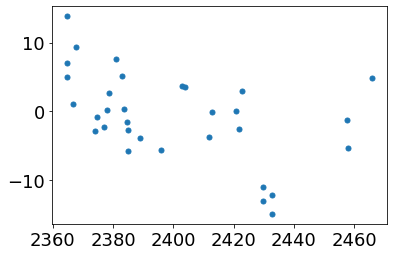

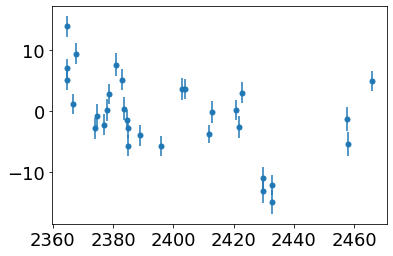

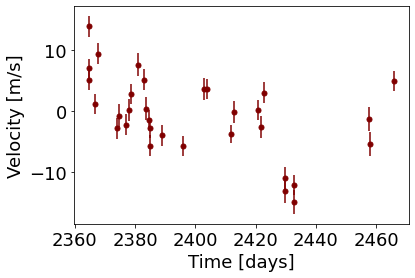

"\n\nIt definitely doesn't appear to be a pure sinusoid. This means there could be significant eccentricity, additional planets,\nstellar activity, or any number of other possible explanations. The periods look like on the order of ~10-20 days,\nor so\n\n\n"

In [3]:
# Let's plot time (data.t) vs radial velocity (data.vel) using matplotlib.pyplot
plt.plot(data.t, data.vel, 'o')

# Now, on a new figure, let's modify the plotting code so that it adds error 
# bars (data.errvel) to each RV measurement
plt.figure()
plt.errorbar(data.t, data.vel, data.errvel, fmt='o')
plt.show()
plt.errorbar(data.t, data.vel, data.errvel, fmt='o',color='maroon')


# Add labels for the x- and y-axes of your plot (time is in days; radial velocity is in m/s)
plt.xlabel('Time [days]')
plt.ylabel('Velocity [m/s]')
plt.show()

# TODO: change the color of the data in your plot

# TODO: What do you notice about the data? Does it look like there is a planet signal? 
# What orbital period would you estimate?
# Enter your answer in the triple quotes below.

"""

It definitely doesn't appear to be a pure sinusoid. This means there could be significant eccentricity, additional planets,
stellar activity, or any number of other possible explanations. The periods look like on the order of ~10-20 days,
or so


"""

## 3. Finding a Significant Period


Now, we will find probable orbital periods using a Lomb-Scargle periodogram. Periodograms are created using a Fourier transform, which is a mathematical process that takes in continuous time-based data and decomposes it into a combination of functions with various frequencies, as seen in the image below. To build more intuition for how a Fourier transform works, checkout this useful [PhET simulation](https://phet.colorado.edu/en/simulation/fourier).

![fourier](https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png "fast fourier transform")
([wikipedia](https://upload.wikimedia.org/wikipedia/commons/6/61/FFT-Time-Frequency-View.png))

The graph on the left is the continous data which is analagous to our radial velocity data. The three sine waves behind the graphs are the functions that are added to produce a good fit to the original data. Finally, the graph on the right is the periodogram. It shows how much each contributing function's frequency contributes to the data model. The larger the peak in the graph, the more significant that frequency is in the data. We use this frequency to get an idea of periodic behaivor in the data (e.g. the orbital period of an exoplanet). Now, we will calculate a periodogram and use it to give us an estimate of the period of the planet's orbit.

In [4]:
def LombScarg(t,v,e,min_per=0.01,max_per=1000):

    #Calculate Generalized Lomb-Scargle periodogram and window function

    fmin = 1./max_per
    fmax = 1./min_per
    frequency, power = LombScargle(t, v, e).autopower(minimum_frequency=1/1000,maximum_frequency=1.,method='cython')

    per = 1/frequency
    #Identify strongest period.
    
    in_window = np.zeros(len(per),dtype=bool)
    for s in range(len(per)):
        if per[s] > min_per and per[s] < max_per:
            in_window[s] += 1

    powmax = max(power[in_window])
    imax = np.argmax(power[in_window])
    fbest = frequency[in_window][imax]
    perbest = 1./fbest

    return per, power, perbest

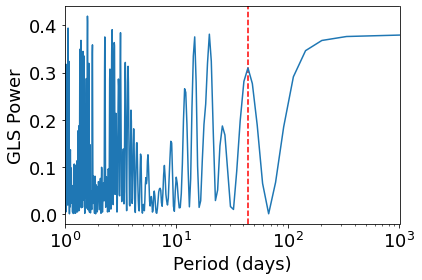

"\n`minPer` and `maxPer` control the period range in which the nyquist searcher looks for significant peaks. Changing\nthem controls which period the searcher returns (it's returning the maximum peak in the allowable range).\n"

In [5]:
minPer = 30 # min period to look for 1st planet (in days)
maxPer = 50 # max period to look for 1st planet (in days)

period, power, period1 = LombScarg(data.t, data.vel,data.errvel,min_per=minPer,max_per=maxPer)
plt.xlim(1,1000)
plt.axvline(period1,color='red',linestyle='--')
plt.semilogx(period,power)
plt.xlabel('Period (days)')
plt.ylabel('GLS Power')
plt.show()


# TODO: change the values of minPer and maxPer. How do the results change? Why? Type your answer
# between the triple quotes below.


"""
`minPer` and `maxPer` control the period range in which the nyquist searcher looks for significant peaks. Changing
them controls which period the searcher returns (it's returning the maximum peak in the allowable range).
"""

## 4. Defining and Initializing Model

Let's define a function that we will use to initialize the ``radvel.Parameters`` and ``radvel.RVModel`` objects.
These will be our initial guesses of the planet parameters based on on the radial velocity measurements shown and periodogram shown above.

In [6]:
nplanets = 1 # number of planets

def initialize_model():
    
    time_base = 2420.
    params = radvel.Parameters(nplanets,basis='per tc secosw sesinw k')
    params['per1'] = radvel.Parameter(value=period1)       # Insert our guess for period of first planet (from periodogram)
    params['tc1'] = radvel.Parameter(value=2080.)      # guess for time of transit of 1st planet
    params['secosw1'] = radvel.Parameter(value=0.0)    # determines eccentricity (assuming circular orbit here)
    params['sesinw1'] = radvel.Parameter(value=0.0)    # determines eccentriciy (assuming circular orbit here)
    params['k1'] = radvel.Parameter(value=3.)          # radial velocity semi-amplitude

    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=-0.02) # possible acceleration of star
    mod.params['curv'] = radvel.Parameter(value=0.01)  # possible curvature in long-term radial velocity trend
    
    return mod


Fit the K2-24 RV data assuming circular orbits.

Set initial guesses for the parameters:

In [7]:
mod = initialize_model() # model initiliazed
like = radvel.likelihood.RVLikelihood(mod, data.t, data.vel, data.errvel, '_HIRES') # initialize Likelihood object

# define initial guesses for instrument-related parameters
like.params['gamma_HIRES'] = radvel.Parameter(value=0.1) # zero-point radial velocity offset
like.params['jit_HIRES'] = radvel.Parameter(value=1.0)   # white noise

Plot the model with our initial parameter guesses:

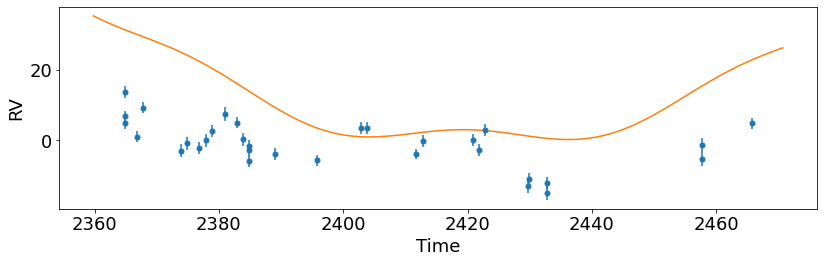

In [8]:
def plot_results(like):
    fig = plt.figure(figsize=(12,4))
    fig = plt.gcf()
    fig.set_tight_layout(True)
    plt.errorbar(
        like.x, like.model(data.t.values)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    
    ti = np.linspace(data.t.iloc[0] - 5, data.t.iloc[-1] + 5,100) # time array for model

    plt.plot(ti, like.model(ti))
    plt.xlabel('Time')
    plt.ylabel('RV')
    
plot_results(like)

## 5. Maximum Likelihood fit

Well, that solution doesn't look very good! Let's optimize the parameters set to vary by maximizing the likelihood.

Initialize a ``radvel.Posterior`` object.

In [9]:
post = radvel.posterior.Posterior(like) # initialize radvel.Posterior object

Choose which parameters to change or hold fixed during a fit. By default, all `radvel.Parameter` objects will vary, so you only have to worry about setting the ones you want to hold fixed.

In [10]:
post.likelihood.params['secosw1'].vary = False # set as false because we are assuming circular orbit
post.likelihood.params['sesinw1'].vary = False # set as false because we are assuming circular orbit
print(like)

parameter                     value      vary
per1                        43.8487       True
tc1                            2080       True
secosw1                           0      False
sesinw1                           0      False
k1                                3       True
dvdt                          -0.02       True
curv                           0.01       True
gamma_HIRES                     0.1       True
jit_HIRES                         1       True



Maximize the likelihood and print the updated posterior object

parameter                     value      vary
per1                        49.0164       True
tc1                         2080.57       True
secosw1                           0      False
sesinw1                           0      False
k1                          3.81242       True
dvdt                     -0.0843784       True
curv                     0.00152179       True
gamma_HIRES                -4.20245       True
jit_HIRES                   3.88509       True

Priors
------



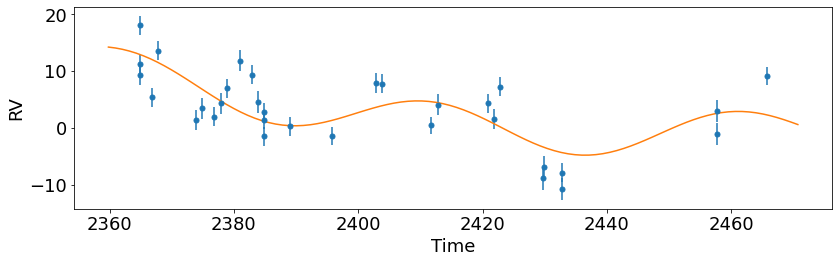

In [11]:
res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print(post)

RadVel comes equipped with some fancy ready-made plotting routines. Check this out!

NOTE: This version of radvel has been modified to NOT include jitters in errorbars.


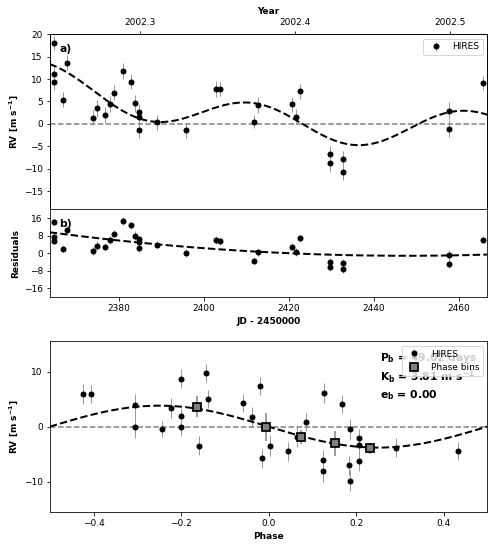

In [12]:
matplotlib.rcParams['font.size'] = 12

RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()

matplotlib.rcParams['font.size'] = 18

## 6. Residuals and Repeat
Residuals are the difference of our data and our best-fit model. 

Next, we will plot the residuals of our optimized model to see if there is a second planet in our data. When we look at the following residuals, we will see a sinusoidal shape, so another planet may be present! Thus, we will repeat the steps shown earlier (this time using the parameters from the maximum fit for the first planet).

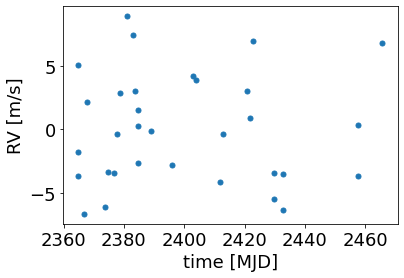

"\n\nThese residuals appear to go up and down every ~20 days or so. This looks like a more convincing version of the\nperiod we first observed in the original radial velocity data. It's still pretty hard to tell, though! I'm \nhappy we have algorithms to find orbital periods more effectively than the human eye can.\n\n\n"

In [13]:
residuals1 = post.likelihood.residuals()

# Let's make a plot of data.time versus `residuals1`
plt.figure()
plt.scatter(data.t, residuals1)
plt.xlabel('time [MJD]')
plt.ylabel('RV [m/s]')
plt.show()

# TODO: What do you notice? What would you estimate the period 
# of the other exoplanet in this system to be? Write your answer between the triple quotes below.

"""

These residuals appear to go up and down every ~20 days or so. This looks like a more convincing version of the
period we first observed in the original radial velocity data. It's still pretty hard to tell, though! I'm 
happy we have algorithms to find orbital periods more effectively than the human eye can.


"""

Let's repeat the above analysis with two planets!

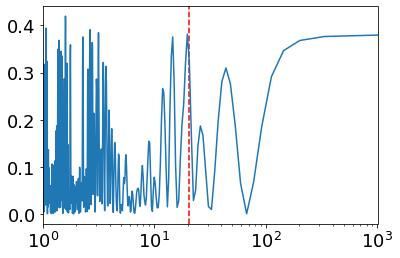

'\nThe period of the first planet is not in the allowed period range we specified (`minPer` to `maxPer`).\n\n'

In [14]:
nyquist = 2 # maximum sampling rate
minPer = 20 # minimum period to look for 2nd planet
maxPer = 30 # max period to look for 2nd planet

# finding 2nd planet period
period, power, period2 = LombScarg(data.t, data.vel, data.errvel, min_per=minPer, max_per=maxPer) # finding possible periords for 2nd planet

period, power, period1 = LombScarg(data.t, data.vel,data.errvel,min_per=minPer,max_per=maxPer)
plt.xlim(1,1000)
plt.axvline(period2,color='red',linestyle='--')
plt.semilogx(period,power)
plt.show()

# TODO: why doesn't the periodogram return the period of the first planet? Write your answer between the triple
#  quotes below.

"""
The period of the first planet is not in the allowed period range we specified (`minPer` to `maxPer`).

"""

Repeat the RadVel analysis

In [15]:
nplanets = 2 # number of planets

def initialize_model():
    
    time_base = 2420
    params = radvel.Parameters(nplanets,basis='per tc secosw sesinw k')
    
    # 1st Planet
    params['per1'] = post.params['per1']     # period of 1st planet
    params['tc1'] = post.params['tc1']      # time transit of 1st planet
    params['secosw1'] = post.params['secosw1']  # determines eccentricity (assuming circular orbit here)
    params['sesinw1'] = post.params['sesinw1']  # determines eccentricity (assuming circular orbit here)
    params['k1'] = post.params['k1']    # velocity semi-amplitude for 1st planet
    
    # 2nd Planet
    params['per2'] = radvel.Parameter(value=period2) # Insert our guess for period of second planet (from periodogram)
    params['tc2'] = radvel.Parameter(value=2070.)
    params['secosw2'] = radvel.Parameter(value=0.0)
    params['sesinw2'] = radvel.Parameter(value=0.0)
    params['k2'] = radvel.Parameter(value=1.1)
  
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=-0.02) # acceleration of star
    mod.params['curv'] = radvel.Parameter(value=0.01)  # curvature of radial velocity fit
    
    return mod


In [16]:
mod = initialize_model() # initialize radvel.RVModel object
like = radvel.likelihood.RVLikelihood(mod, data.t, data.vel, data.errvel, '_HIRES')
like.params['gamma_HIRES'] = radvel.Parameter(value=0.1)
like.params['jit_HIRES'] = radvel.Parameter(value=1.0)

In [17]:
like.params['secosw1'].vary = False # set as false because we are assuming circular orbit
like.params['sesinw1'].vary = False 
like.params['secosw2'].vary = False # set as false because we are assuming circular orbit
like.params['sesinw2'].vary = False 

print(like)

parameter                     value      vary
per1                        49.0164       True
tc1                         2080.57       True
secosw1                           0      False
sesinw1                           0      False
k1                          3.81242       True
per2                        20.5863       True
tc2                            2070       True
secosw2                           0      False
sesinw2                           0      False
k2                              1.1       True
dvdt                          -0.02       True
curv                           0.01       True
gamma_HIRES                     0.1       True
jit_HIRES                         1       True



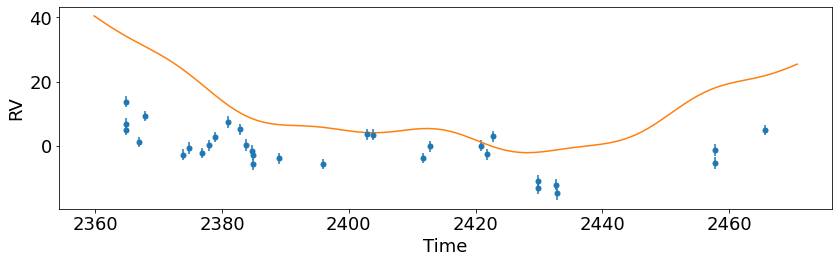

In [18]:
plot_results(like)

parameter                     value      vary
per1                        48.4701       True
tc1                          2083.1       True
secosw1                           0      False
sesinw1                           0      False
k1                          4.39734       True
per2                         21.126       True
tc2                         2069.83       True
secosw2                           0      False
sesinw2                           0      False
k2                           4.7912       True
dvdt                     -0.0630582       True
curv                     0.00152013       True
gamma_HIRES                 -4.0217       True
jit_HIRES                   2.27605       True

Priors
------



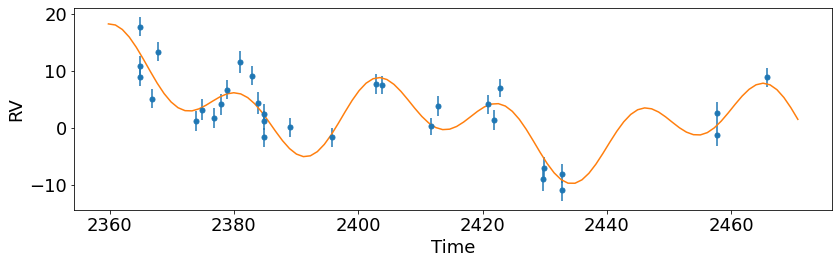

In [19]:
post = radvel.posterior.Posterior(like) # initialize radvel.Posterior object

res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Powell',           # Nelder-Mead also works
    )

plot_results(like)             # plot best fit model
print(post)

NOTE: This version of radvel has been modified to NOT include jitters in errorbars.


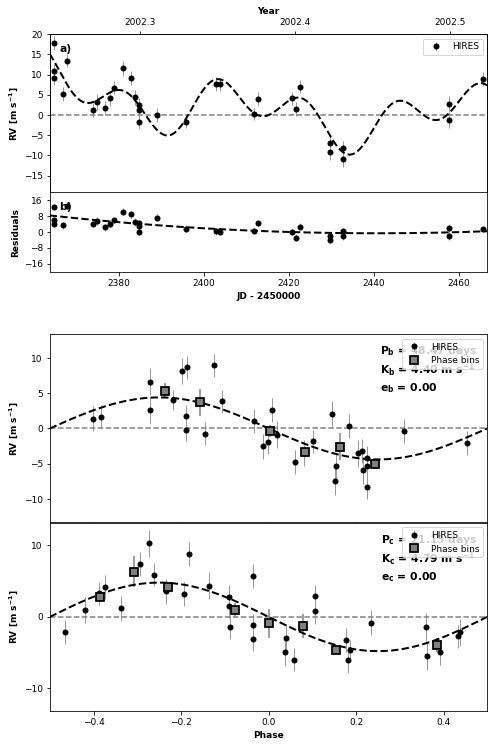

In [20]:
matplotlib.rcParams['font.size'] = 12

RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()

matplotlib.rcParams['font.size'] = 18

'\n\nThe easiest way to do this is to rerun the analysis, except whenever you see a line that says secosw1 = False,\nor sesinw1 = False, or secosw2 = False, or sesinw2 = False, you change them to True.\n\nBe careful not to let the model go too crazy with eccentricity, try giving them initial guesses of 0.1.\n\nThe planet RV signatures look more angular (less purely sinusoidal) now that they have a non-zero eccentricity.\nThe data appears to be better-fit by an eccentric orbit model (i.e. the planets probably do have non-negligible\neccentricities).\n'

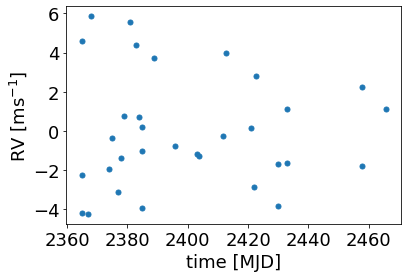

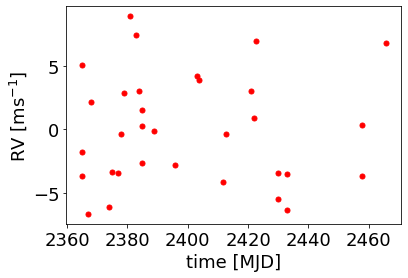

In [21]:
residuals2 = post.likelihood.residuals()

# TODO: make a plot of data.time versus `residuals2`. What do you notice?

# TODO: try redoing the above analysis, but this time, allow the eccentricity parameters to vary during the fit.
#  How does the fit change?

plt.figure()
plt.scatter(data.t, residuals2)
plt.xlabel('time [MJD]')
plt.ylabel('RV [ms$^{-1}$]')

# Here's the original residuals plot, for comparison purposes:
plt.figure()
plt.scatter(data.t, residuals1, color='red')
plt.xlabel('time [MJD]')
plt.ylabel('RV [ms$^{-1}$]')

"""
The residuals perhaps look a little more randomly distributed than before, but again it's pretty hard to tell
without a periodogram.
"""



"""

The easiest way to do this is to rerun the analysis, except whenever you see a line that says secosw1 = False,
or sesinw1 = False, or secosw2 = False, or sesinw2 = False, you change them to True.

Be careful not to let the model go too crazy with eccentricity, try giving them initial guesses of 0.1.

The planet RV signatures look more angular (less purely sinusoidal) now that they have a non-zero eccentricity.
The data appears to be better-fit by an eccentric orbit model (i.e. the planets probably do have non-negligible
eccentricities).
"""

K2-24 only has two known exoplanets so will stop this part of our analysis here. However, when analzying an uncharacterized star system, it's important to continue the analysis until we see no significant reduction in the residuals of the radial velocity. 

# 7. Markov Chain Monte Carlo (MCMC)
After reading the intro to MCMC blog post at the beginning of this tutorial, you are an expert on MCMC! Write a 3-sentence introduction to this section yourself. 

MCMC is a method of exploring the parameter space of probable orbits using random walks, i.e. randomly changing the parameters of the fit. MCMC is used to find the most probable orbital solution and to determine the uncertainty (error bars) in the fit. MCMC tells you the probability distributions of orbital parameters consistent with the data.

In [40]:
# TODO: edit the Markdown cell immediately above this one with a 3 sentence description of the MCMC method.
#  What does MCMC do? Why do you think it is important to use MCMC to characterize uncertainties in radial
#  velocity fits?

Let's use RadVel to perform an MCMC fit:

In [22]:
df = radvel.mcmc(post, nwalkers=50, nrun=1000)

# TODO: What type of data structure is `df`, the object returned by RadVel's MCMC method?

"""
It is a pandas dataframe
"""

20000/400000 (5.0%) steps complete; Running 15855.08 steps/s; Mean acceptance rate = 48.2%; Min Auto Factor =  19; Max Auto Relative-Change =   inf; Min Tz = 6614.6; Max G-R = 1.004
Discarding burn-in now that the chains are marginally well-mixed

400000/400000 (100.0%) steps complete; Running 15030.55 steps/s; Mean acceptance rate = 37.4%; Min Auto Factor =  39; Max Auto Relative-Change = 0.0724; Min Tz = 1595.8; Max G-R = 1.018

MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


'\nIt is a pandas dataframe\n'

Make a fun plot!

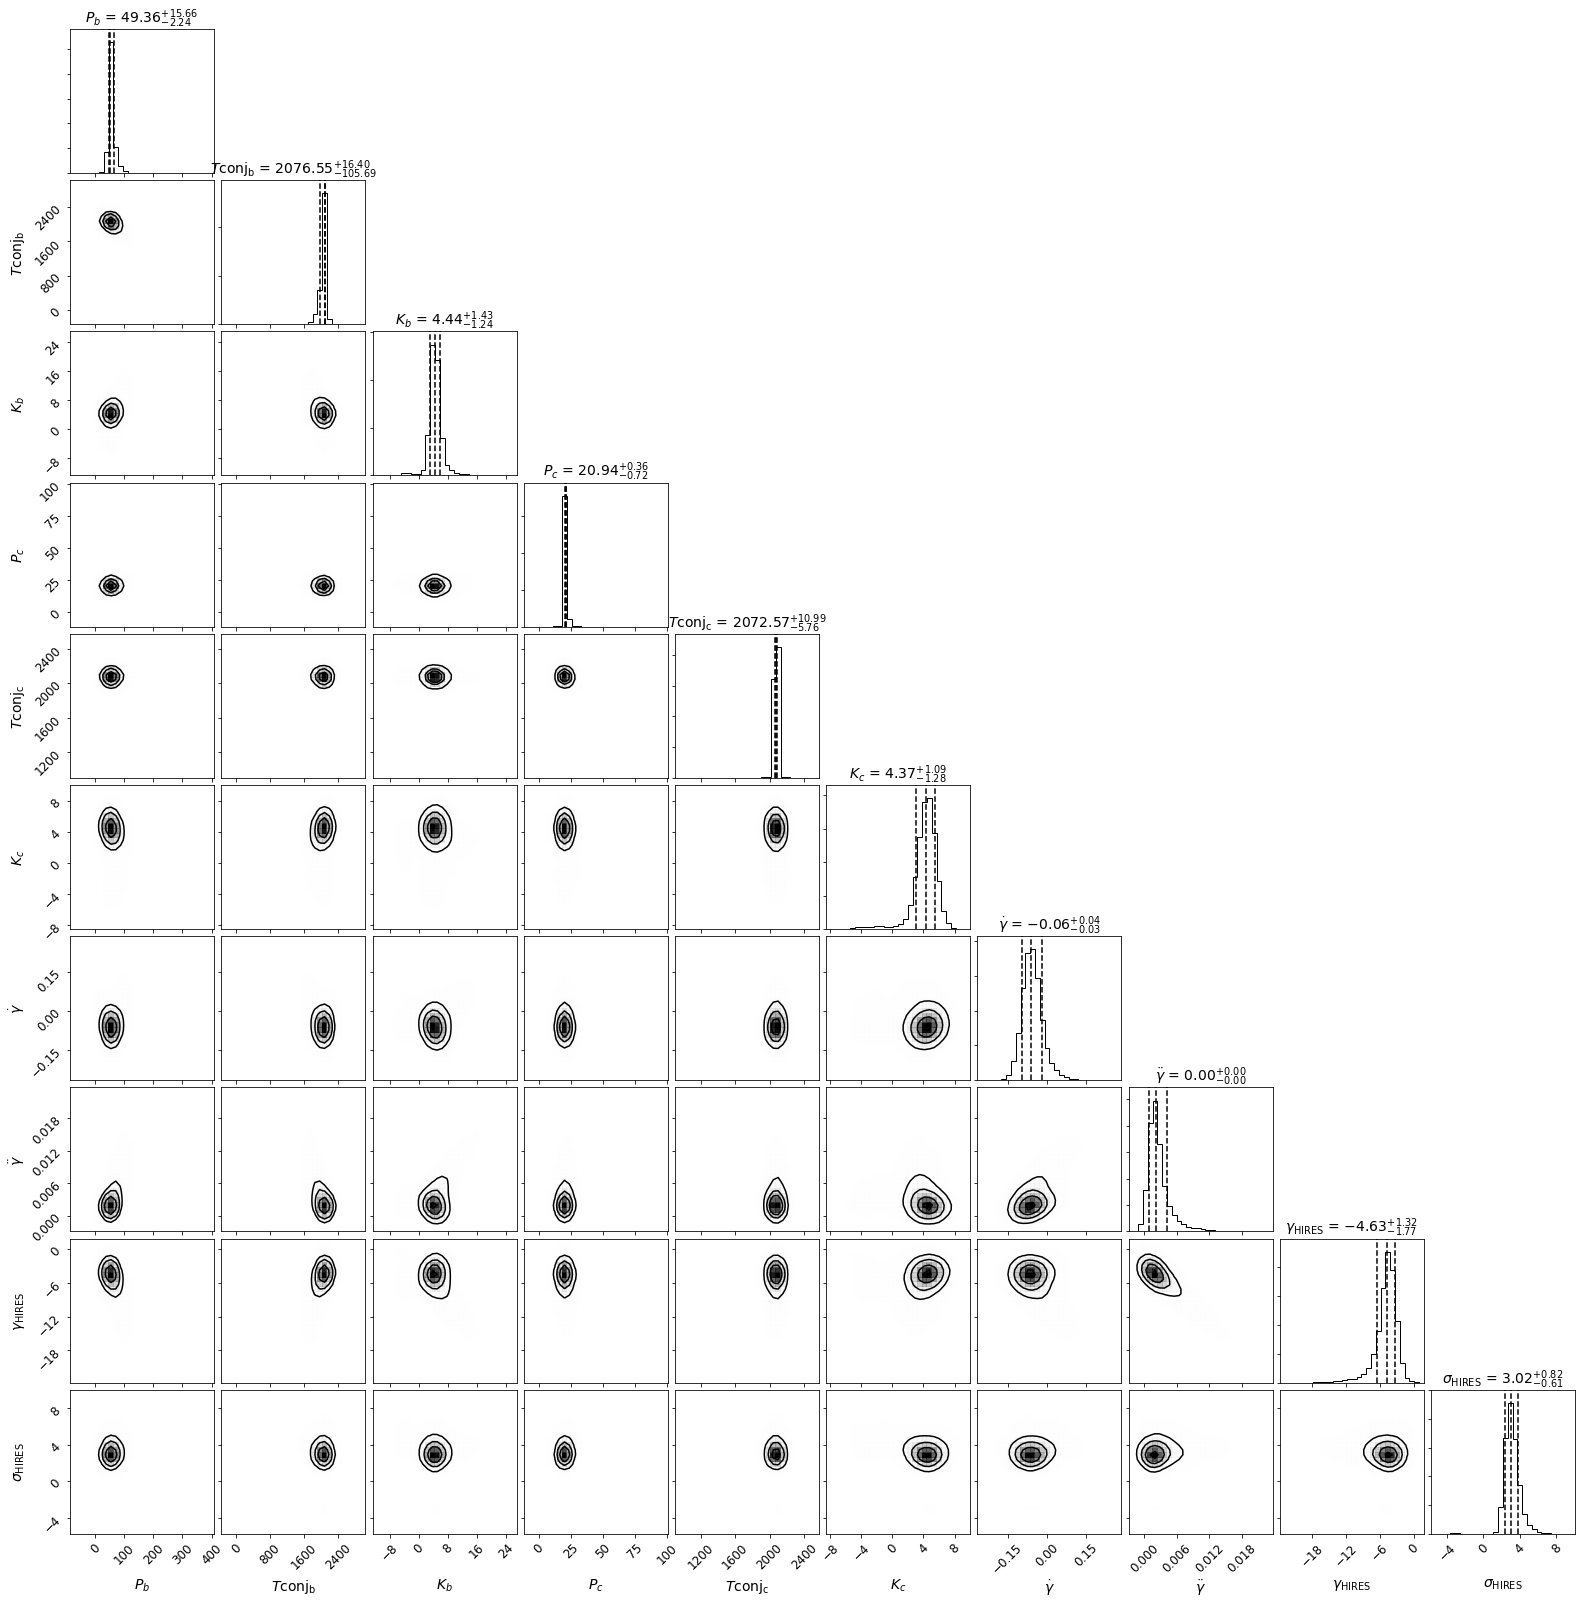

"\nThe off-diagonal boxes are 1 dimensional probability distributions over each of the parameters of the fit.\nThe on-diagonal boxes show 2 dimensional probability distributions (covariances) between pairs of parameters\n(the box's row and column show the parameters it corresponds to).\nThe median period of the first plot (for my eccentric fit) is 52.56 days. The uncertainty is +0.08 days, -0.07 days\n(this corresponds to a *68% confidence interval* of [52.49, 52.64] days.)\nThe median period of the second planet is 20.69 days, with an uncertainty of +/- 0.02 days. \nThe uncertainties of the two orbital periods are different because the period of the second planet is much better\nconstrained by the data than the period of the first planet. We see many periods of the second planet repeated\nover the ~100 day dataset, but only ~2 periods of the first planet.\n\n"

In [23]:
Corner = mcmc_plots.CornerPlot(post, df)
Corner.plot()

# TODO: There is a lot going on in this plot. What do you think the off-diagonal boxes are showing? 
#  What about the on-diagonal boxes? What is the median period of the first planet? 
#  What is the uncertainty on the period of the first planet? The second planet?
# TODO: Why do you think the uncertainties on the periods of planets b and c are different?

"""
The off-diagonal boxes are 1 dimensional probability distributions over each of the parameters of the fit.
The on-diagonal boxes show 2 dimensional probability distributions (covariances) between pairs of parameters
(the box's row and column show the parameters it corresponds to).
The median period of the first plot (for my eccentric fit) is 52.56 days. The uncertainty is +0.08 days, -0.07 days
(this corresponds to a *68% confidence interval* of [52.49, 52.64] days.)
The median period of the second planet is 20.69 days, with an uncertainty of +/- 0.02 days. 
The uncertainties of the two orbital periods are different because the period of the second planet is much better
constrained by the data than the period of the first planet. We see many periods of the second planet repeated
over the ~100 day dataset, but only ~2 periods of the first planet.

"""